# 사용자 행동 인식 데이터 세트

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [2]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'-'+str(x[1]) if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop('index',axis=1)
    return new_feature_name_df

In [4]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [5]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [6]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n',dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [8]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6,8,10,12,16,20,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.5min finished


GridSearchCV 최고 평균 정확도 수치: 0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [9]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [10]:
max_depths = [6,8,10,12,16,20,24]
# max_depths 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


In [11]:
params = {
    'max_depth':[8,12,16,20],
    'min_samples_split':[16,24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train,y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.8min finished


GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [12]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


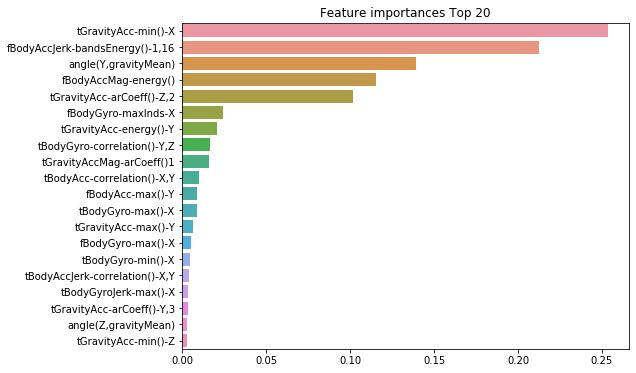

In [13]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y = ftr_top20.index)
plt.show()

# 캐글 산탄데르 고객 만족 예측

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("./santander-customer-satisfaction/train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [16]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [17]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format(unsatisfied_cnt / total_cnt))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [18]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [19]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID',axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85830	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.880

In [22]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5,7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv를 지정하지 않음. 
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.71637	validation_1-auc:0.72122
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.81667	validation_1-auc:0.82080
[2]	validation_0-auc:0.81000	validation_1-auc:0.80797
[3]	validation_0-auc:0.82332	validation_1-auc:0.82217
[4]	validation_0-auc:0.83181	validation_1-auc:0.82882
[5]	validation_0-auc:0.82935	validation_1-auc:0.82418
[6]	validation_0-auc:0.82908	validation_1-auc:0.82355
[7]	validation_0-auc:0.83956	validation_1-auc:0.83139
[8]	validation_0-auc:0.84448	validation_1-auc:0.83360
[9]	validation_0-auc:0.84482	validation_1-auc:0.83160
[10]	validation_0-auc:0.85138	validation_1-auc:0.83624
[11]	validation_0-auc:0.85383	validation_1-auc:0.83745
[12]	validation_0-auc:0.85630	validation_1-auc:0.83870
[13]	validation_0-auc:0.85803	validation_1-auc:0.83806
[14]	validation_0-auc:0.85968	validation_1-auc:0.83747
[15]	validation_0-auc:0.8611

[45]	validation_0-auc:0.88390	validation_1-auc:0.83915
[46]	validation_0-auc:0.88402	validation_1-auc:0.83925
[47]	validation_0-auc:0.88467	validation_1-auc:0.83895
[48]	validation_0-auc:0.88505	validation_1-auc:0.83867
[49]	validation_0-auc:0.88532	validation_1-auc:0.83881
[50]	validation_0-auc:0.88575	validation_1-auc:0.83839
[51]	validation_0-auc:0.88653	validation_1-auc:0.83864
[52]	validation_0-auc:0.88671	validation_1-auc:0.83867
[53]	validation_0-auc:0.88687	validation_1-auc:0.83825
[54]	validation_0-auc:0.88755	validation_1-auc:0.83807
[55]	validation_0-auc:0.88788	validation_1-auc:0.83777
[56]	validation_0-auc:0.88869	validation_1-auc:0.83779
Stopping. Best iteration:
[26]	validation_0-auc:0.87262	validation_1-auc:0.84394

[0]	validation_0-auc:0.71000	validation_1-auc:0.71605
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.81240	validation_1-auc:0

[11]	validation_0-auc:0.85355	validation_1-auc:0.84099
[12]	validation_0-auc:0.85633	validation_1-auc:0.84194
[13]	validation_0-auc:0.85770	validation_1-auc:0.84140
[14]	validation_0-auc:0.85874	validation_1-auc:0.84101
[15]	validation_0-auc:0.86020	validation_1-auc:0.84125
[16]	validation_0-auc:0.86199	validation_1-auc:0.84168
[17]	validation_0-auc:0.86333	validation_1-auc:0.84146
[18]	validation_0-auc:0.86436	validation_1-auc:0.84102
[19]	validation_0-auc:0.86521	validation_1-auc:0.84127
[20]	validation_0-auc:0.86628	validation_1-auc:0.84131
[21]	validation_0-auc:0.86664	validation_1-auc:0.84171
[22]	validation_0-auc:0.86692	validation_1-auc:0.84188
[23]	validation_0-auc:0.86778	validation_1-auc:0.84156
[24]	validation_0-auc:0.86838	validation_1-auc:0.84223
[25]	validation_0-auc:0.86962	validation_1-auc:0.84163
[26]	validation_0-auc:0.87015	validation_1-auc:0.84150
[27]	validation_0-auc:0.87069	validation_1-auc:0.84116
[28]	validation_0-auc:0.87157	validation_1-auc:0.84123
[29]	valid

[40]	validation_0-auc:0.87541	validation_1-auc:0.84186
[41]	validation_0-auc:0.87576	validation_1-auc:0.84179
[42]	validation_0-auc:0.87589	validation_1-auc:0.84219
[43]	validation_0-auc:0.87633	validation_1-auc:0.84193
[44]	validation_0-auc:0.87764	validation_1-auc:0.84120
[45]	validation_0-auc:0.87780	validation_1-auc:0.84089
[46]	validation_0-auc:0.87814	validation_1-auc:0.84076
Stopping. Best iteration:
[16]	validation_0-auc:0.86229	validation_1-auc:0.84436

[0]	validation_0-auc:0.72420	validation_1-auc:0.72803
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.81944	validation_1-auc:0.81883
[2]	validation_0-auc:0.81367	validation_1-auc:0.81598
[3]	validation_0-auc:0.82820	validation_1-auc:0.82949
[4]	validation_0-auc:0.83396	validation_1-auc:0.83132
[5]	validation_0-auc:0.83077	validation_1-auc:0.82733
[6]	validation_0-auc:0.82948	validation_1-auc:0.8249

[21]	validation_0-auc:0.89180	validation_1-auc:0.83770
[22]	validation_0-auc:0.89223	validation_1-auc:0.83712
[23]	validation_0-auc:0.89277	validation_1-auc:0.83707
[24]	validation_0-auc:0.89316	validation_1-auc:0.83769
[25]	validation_0-auc:0.89411	validation_1-auc:0.83787
[26]	validation_0-auc:0.89468	validation_1-auc:0.83768
[27]	validation_0-auc:0.89523	validation_1-auc:0.83751
[28]	validation_0-auc:0.89605	validation_1-auc:0.83671
[29]	validation_0-auc:0.89640	validation_1-auc:0.83627
[30]	validation_0-auc:0.89653	validation_1-auc:0.83618
[31]	validation_0-auc:0.89704	validation_1-auc:0.83585
[32]	validation_0-auc:0.89728	validation_1-auc:0.83626
[33]	validation_0-auc:0.89751	validation_1-auc:0.83641
[34]	validation_0-auc:0.89783	validation_1-auc:0.83619
[35]	validation_0-auc:0.89824	validation_1-auc:0.83579
[36]	validation_0-auc:0.89834	validation_1-auc:0.83576
[37]	validation_0-auc:0.89852	validation_1-auc:0.83580
[38]	validation_0-auc:0.89869	validation_1-auc:0.83592
[39]	valid

[16]	validation_0-auc:0.88616	validation_1-auc:0.84360
[17]	validation_0-auc:0.88713	validation_1-auc:0.84348
[18]	validation_0-auc:0.88855	validation_1-auc:0.84395
[19]	validation_0-auc:0.89010	validation_1-auc:0.84379
[20]	validation_0-auc:0.89104	validation_1-auc:0.84312
[21]	validation_0-auc:0.89245	validation_1-auc:0.84308
[22]	validation_0-auc:0.89266	validation_1-auc:0.84278
[23]	validation_0-auc:0.89359	validation_1-auc:0.84303
[24]	validation_0-auc:0.89376	validation_1-auc:0.84321
[25]	validation_0-auc:0.89509	validation_1-auc:0.84288
[26]	validation_0-auc:0.89555	validation_1-auc:0.84229
[27]	validation_0-auc:0.89590	validation_1-auc:0.84230
[28]	validation_0-auc:0.89676	validation_1-auc:0.84148
[29]	validation_0-auc:0.89804	validation_1-auc:0.84055
[30]	validation_0-auc:0.89896	validation_1-auc:0.83984
[31]	validation_0-auc:0.89903	validation_1-auc:0.83996
[32]	validation_0-auc:0.89971	validation_1-auc:0.83965
[33]	validation_0-auc:0.90028	validation_1-auc:0.83998
[34]	valid

[50]	validation_0-auc:0.89874	validation_1-auc:0.83751
[51]	validation_0-auc:0.89956	validation_1-auc:0.83738
[52]	validation_0-auc:0.90037	validation_1-auc:0.83714
[53]	validation_0-auc:0.90057	validation_1-auc:0.83715
[54]	validation_0-auc:0.90070	validation_1-auc:0.83717
[55]	validation_0-auc:0.90085	validation_1-auc:0.83730
[56]	validation_0-auc:0.90136	validation_1-auc:0.83784
[57]	validation_0-auc:0.90170	validation_1-auc:0.83789
[58]	validation_0-auc:0.90248	validation_1-auc:0.83778
[59]	validation_0-auc:0.90247	validation_1-auc:0.83755
Stopping. Best iteration:
[29]	validation_0-auc:0.88901	validation_1-auc:0.84106

[0]	validation_0-auc:0.74582	validation_1-auc:0.74973
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82443	validation_1-auc:0.81667
[2]	validation_0-auc:0.81850	validation_1-auc:0.81269
[3]	validation_0-auc:0.83495	validation_1-auc:0.8

[6]	validation_0-auc:0.84355	validation_1-auc:0.82984
[7]	validation_0-auc:0.85128	validation_1-auc:0.83560
[8]	validation_0-auc:0.85791	validation_1-auc:0.83791
[9]	validation_0-auc:0.85925	validation_1-auc:0.83618
[10]	validation_0-auc:0.86447	validation_1-auc:0.83961
[11]	validation_0-auc:0.86884	validation_1-auc:0.84095
[12]	validation_0-auc:0.87074	validation_1-auc:0.84299
[13]	validation_0-auc:0.87167	validation_1-auc:0.84173
[14]	validation_0-auc:0.87292	validation_1-auc:0.84290
[15]	validation_0-auc:0.87511	validation_1-auc:0.84474
[16]	validation_0-auc:0.87722	validation_1-auc:0.84571
[17]	validation_0-auc:0.87909	validation_1-auc:0.84628
[18]	validation_0-auc:0.88033	validation_1-auc:0.84541
[19]	validation_0-auc:0.88052	validation_1-auc:0.84542
[20]	validation_0-auc:0.88189	validation_1-auc:0.84476
[21]	validation_0-auc:0.88370	validation_1-auc:0.84416
[22]	validation_0-auc:0.88387	validation_1-auc:0.84407
[23]	validation_0-auc:0.88435	validation_1-auc:0.84381
[24]	validatio

[4]	validation_0-auc:0.83775	validation_1-auc:0.83014
[5]	validation_0-auc:0.84075	validation_1-auc:0.83093
[6]	validation_0-auc:0.84467	validation_1-auc:0.83488
[7]	validation_0-auc:0.84782	validation_1-auc:0.83653
[8]	validation_0-auc:0.85040	validation_1-auc:0.83817
[9]	validation_0-auc:0.85225	validation_1-auc:0.83957
[10]	validation_0-auc:0.85348	validation_1-auc:0.83878
[11]	validation_0-auc:0.85528	validation_1-auc:0.83852
[12]	validation_0-auc:0.85792	validation_1-auc:0.83908
[13]	validation_0-auc:0.86108	validation_1-auc:0.84071
[14]	validation_0-auc:0.86281	validation_1-auc:0.84112
[15]	validation_0-auc:0.86393	validation_1-auc:0.84179
[16]	validation_0-auc:0.86484	validation_1-auc:0.84094
[17]	validation_0-auc:0.86633	validation_1-auc:0.84091
[18]	validation_0-auc:0.86731	validation_1-auc:0.84057
[19]	validation_0-auc:0.86827	validation_1-auc:0.84050
[20]	validation_0-auc:0.86939	validation_1-auc:0.84101
[21]	validation_0-auc:0.86999	validation_1-auc:0.84105
[22]	validation_

[28]	validation_0-auc:0.87425	validation_1-auc:0.84246
[29]	validation_0-auc:0.87467	validation_1-auc:0.84211
[30]	validation_0-auc:0.87547	validation_1-auc:0.84215
[31]	validation_0-auc:0.87553	validation_1-auc:0.84205
[32]	validation_0-auc:0.87577	validation_1-auc:0.84169
[33]	validation_0-auc:0.87608	validation_1-auc:0.84173
[34]	validation_0-auc:0.87673	validation_1-auc:0.84124
[35]	validation_0-auc:0.87737	validation_1-auc:0.84164
[36]	validation_0-auc:0.87879	validation_1-auc:0.84184
[37]	validation_0-auc:0.87952	validation_1-auc:0.84184
[38]	validation_0-auc:0.87976	validation_1-auc:0.84175
[39]	validation_0-auc:0.88007	validation_1-auc:0.84181
[40]	validation_0-auc:0.88031	validation_1-auc:0.84168
[41]	validation_0-auc:0.88052	validation_1-auc:0.84149
[42]	validation_0-auc:0.88132	validation_1-auc:0.84166
[43]	validation_0-auc:0.88165	validation_1-auc:0.84131
[44]	validation_0-auc:0.88177	validation_1-auc:0.84135
[45]	validation_0-auc:0.88292	validation_1-auc:0.84191
[46]	valid

[51]	validation_0-auc:0.88177	validation_1-auc:0.83725
[52]	validation_0-auc:0.88229	validation_1-auc:0.83736
[53]	validation_0-auc:0.88241	validation_1-auc:0.83784
[54]	validation_0-auc:0.88255	validation_1-auc:0.83750
[55]	validation_0-auc:0.88306	validation_1-auc:0.83736
Stopping. Best iteration:
[25]	validation_0-auc:0.87026	validation_1-auc:0.84113

[0]	validation_0-auc:0.81453	validation_1-auc:0.81253
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82597	validation_1-auc:0.81893
[2]	validation_0-auc:0.82747	validation_1-auc:0.82330
[3]	validation_0-auc:0.83588	validation_1-auc:0.83066
[4]	validation_0-auc:0.83825	validation_1-auc:0.83114
[5]	validation_0-auc:0.84066	validation_1-auc:0.83104
[6]	validation_0-auc:0.84463	validation_1-auc:0.83394
[7]	validation_0-auc:0.84641	validation_1-auc:0.83530
[8]	validation_0-auc:0.84883	validation_1-auc:0.83845


[31]	validation_0-auc:0.87079	validation_1-auc:0.84129
[32]	validation_0-auc:0.87129	validation_1-auc:0.84094
[33]	validation_0-auc:0.87266	validation_1-auc:0.84097
[34]	validation_0-auc:0.87307	validation_1-auc:0.84125
[35]	validation_0-auc:0.87413	validation_1-auc:0.84091
[36]	validation_0-auc:0.87464	validation_1-auc:0.84114
[37]	validation_0-auc:0.87481	validation_1-auc:0.84089
[38]	validation_0-auc:0.87491	validation_1-auc:0.84105
[39]	validation_0-auc:0.87506	validation_1-auc:0.84115
[40]	validation_0-auc:0.87534	validation_1-auc:0.84088
[41]	validation_0-auc:0.87589	validation_1-auc:0.84108
[42]	validation_0-auc:0.87616	validation_1-auc:0.84073
[43]	validation_0-auc:0.87696	validation_1-auc:0.84029
[44]	validation_0-auc:0.87732	validation_1-auc:0.84014
[45]	validation_0-auc:0.87729	validation_1-auc:0.84010
[46]	validation_0-auc:0.87808	validation_1-auc:0.83995
Stopping. Best iteration:
[16]	validation_0-auc:0.86059	validation_1-auc:0.84260

[0]	validation_0-auc:0.81949	validatio

[19]	validation_0-auc:0.89035	validation_1-auc:0.84090
[20]	validation_0-auc:0.89252	validation_1-auc:0.84097
[21]	validation_0-auc:0.89354	validation_1-auc:0.84043
[22]	validation_0-auc:0.89420	validation_1-auc:0.84083
[23]	validation_0-auc:0.89573	validation_1-auc:0.84062
[24]	validation_0-auc:0.89618	validation_1-auc:0.84071
[25]	validation_0-auc:0.89731	validation_1-auc:0.84030
[26]	validation_0-auc:0.90082	validation_1-auc:0.84004
[27]	validation_0-auc:0.90107	validation_1-auc:0.84016
[28]	validation_0-auc:0.90120	validation_1-auc:0.84019
[29]	validation_0-auc:0.90196	validation_1-auc:0.84025
[30]	validation_0-auc:0.90266	validation_1-auc:0.84120
[31]	validation_0-auc:0.90403	validation_1-auc:0.84118
[32]	validation_0-auc:0.90446	validation_1-auc:0.84066
[33]	validation_0-auc:0.90490	validation_1-auc:0.84052
[34]	validation_0-auc:0.90509	validation_1-auc:0.84065
[35]	validation_0-auc:0.90655	validation_1-auc:0.84084
[36]	validation_0-auc:0.90673	validation_1-auc:0.84102
[37]	valid

[18]	validation_0-auc:0.89349	validation_1-auc:0.83618
[19]	validation_0-auc:0.89545	validation_1-auc:0.83514
[20]	validation_0-auc:0.89655	validation_1-auc:0.83590
[21]	validation_0-auc:0.89695	validation_1-auc:0.83601
[22]	validation_0-auc:0.89771	validation_1-auc:0.83635
[23]	validation_0-auc:0.89865	validation_1-auc:0.83581
[24]	validation_0-auc:0.90023	validation_1-auc:0.83576
[25]	validation_0-auc:0.90063	validation_1-auc:0.83581
[26]	validation_0-auc:0.90138	validation_1-auc:0.83501
[27]	validation_0-auc:0.90205	validation_1-auc:0.83412
[28]	validation_0-auc:0.90214	validation_1-auc:0.83424
[29]	validation_0-auc:0.90268	validation_1-auc:0.83427
[30]	validation_0-auc:0.90291	validation_1-auc:0.83437
[31]	validation_0-auc:0.90442	validation_1-auc:0.83465
[32]	validation_0-auc:0.90513	validation_1-auc:0.83436
[33]	validation_0-auc:0.90601	validation_1-auc:0.83385
[34]	validation_0-auc:0.90657	validation_1-auc:0.83374
[35]	validation_0-auc:0.90680	validation_1-auc:0.83374
[36]	valid

[26]	validation_0-auc:0.89161	validation_1-auc:0.83688
[27]	validation_0-auc:0.89264	validation_1-auc:0.83604
[28]	validation_0-auc:0.89498	validation_1-auc:0.83483
[29]	validation_0-auc:0.89514	validation_1-auc:0.83486
[30]	validation_0-auc:0.89670	validation_1-auc:0.83437
[31]	validation_0-auc:0.89695	validation_1-auc:0.83459
[32]	validation_0-auc:0.89727	validation_1-auc:0.83380
[33]	validation_0-auc:0.89773	validation_1-auc:0.83356
[34]	validation_0-auc:0.89843	validation_1-auc:0.83311
[35]	validation_0-auc:0.89875	validation_1-auc:0.83294
[36]	validation_0-auc:0.89946	validation_1-auc:0.83246
[37]	validation_0-auc:0.89959	validation_1-auc:0.83248
[38]	validation_0-auc:0.89963	validation_1-auc:0.83266
[39]	validation_0-auc:0.90005	validation_1-auc:0.83256
[40]	validation_0-auc:0.90037	validation_1-auc:0.83252
[41]	validation_0-auc:0.90047	validation_1-auc:0.83253
[42]	validation_0-auc:0.90137	validation_1-auc:0.83262
Stopping. Best iteration:
[12]	validation_0-auc:0.87331	validatio

[19]	validation_0-auc:0.89669	validation_1-auc:0.83827
[20]	validation_0-auc:0.89785	validation_1-auc:0.83869
[21]	validation_0-auc:0.89853	validation_1-auc:0.83904
[22]	validation_0-auc:0.90065	validation_1-auc:0.83884
[23]	validation_0-auc:0.90231	validation_1-auc:0.83910
[24]	validation_0-auc:0.90267	validation_1-auc:0.83940
[25]	validation_0-auc:0.90309	validation_1-auc:0.83900
[26]	validation_0-auc:0.90363	validation_1-auc:0.83876
[27]	validation_0-auc:0.90398	validation_1-auc:0.83905
[28]	validation_0-auc:0.90569	validation_1-auc:0.83826
[29]	validation_0-auc:0.90601	validation_1-auc:0.83827
[30]	validation_0-auc:0.90651	validation_1-auc:0.83860
[31]	validation_0-auc:0.90709	validation_1-auc:0.83868
[32]	validation_0-auc:0.90734	validation_1-auc:0.83905
[33]	validation_0-auc:0.90796	validation_1-auc:0.83914
[34]	validation_0-auc:0.90826	validation_1-auc:0.83904
[35]	validation_0-auc:0.90946	validation_1-auc:0.83887
[36]	validation_0-auc:0.91170	validation_1-auc:0.83828
[37]	valid

In [24]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=5,\
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.81728	validation_1-auc:0.81153
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.82030	validation_1-auc:0.81218
[2]	validation_0-auc:0.82336	validation_1-auc:0.81603
[3]	validation_0-auc:0.82501	validation_1-auc:0.81705
[4]	validation_0-auc:0.82524	validation_1-auc:0.81726
[5]	validation_0-auc:0.82756	validation_1-auc:0.81999
[6]	validation_0-auc:0.82781	validation_1-auc:0.81954
[7]	validation_0-auc:0.82786	validation_1-auc:0.81922
[8]	validation_0-auc:0.82922	validation_1-auc:0.81980
[9]	validation_0-auc:0.82908	validation_1-auc:0.81890
[10]	validation_0-auc:0.83073	validation_1-auc:0.82097
[11]	validation_0-auc:0.82829	validation_1-auc:0.81944
[12]	validation_0-auc:0.82961	validation_1-auc:0.82120
[13]	validation_0-auc:0.83049	validation_1-auc:0.82112
[14]	validation_0-auc:0.83489	validation_1-auc:0.82707
[15]	validation_0-auc:0.833

[146]	validation_0-auc:0.85682	validation_1-auc:0.84100
[147]	validation_0-auc:0.85686	validation_1-auc:0.84111
[148]	validation_0-auc:0.85685	validation_1-auc:0.84122
[149]	validation_0-auc:0.85685	validation_1-auc:0.84115
[150]	validation_0-auc:0.85678	validation_1-auc:0.84114
[151]	validation_0-auc:0.85675	validation_1-auc:0.84131
[152]	validation_0-auc:0.85665	validation_1-auc:0.84144
[153]	validation_0-auc:0.85664	validation_1-auc:0.84159
[154]	validation_0-auc:0.85696	validation_1-auc:0.84163
[155]	validation_0-auc:0.85701	validation_1-auc:0.84167
[156]	validation_0-auc:0.85730	validation_1-auc:0.84163
[157]	validation_0-auc:0.85754	validation_1-auc:0.84167
[158]	validation_0-auc:0.85776	validation_1-auc:0.84175
[159]	validation_0-auc:0.85793	validation_1-auc:0.84176
[160]	validation_0-auc:0.85815	validation_1-auc:0.84176
[161]	validation_0-auc:0.85824	validation_1-auc:0.84188
[162]	validation_0-auc:0.85847	validation_1-auc:0.84179
[163]	validation_0-auc:0.85856	validation_1-auc:

[293]	validation_0-auc:0.87364	validation_1-auc:0.84313
[294]	validation_0-auc:0.87369	validation_1-auc:0.84311
[295]	validation_0-auc:0.87377	validation_1-auc:0.84309
[296]	validation_0-auc:0.87385	validation_1-auc:0.84314
[297]	validation_0-auc:0.87399	validation_1-auc:0.84317
[298]	validation_0-auc:0.87409	validation_1-auc:0.84320
[299]	validation_0-auc:0.87417	validation_1-auc:0.84323
[300]	validation_0-auc:0.87421	validation_1-auc:0.84323
[301]	validation_0-auc:0.87431	validation_1-auc:0.84323
[302]	validation_0-auc:0.87444	validation_1-auc:0.84324
[303]	validation_0-auc:0.87457	validation_1-auc:0.84326
[304]	validation_0-auc:0.87468	validation_1-auc:0.84327
[305]	validation_0-auc:0.87477	validation_1-auc:0.84323
[306]	validation_0-auc:0.87489	validation_1-auc:0.84315
[307]	validation_0-auc:0.87498	validation_1-auc:0.84317
[308]	validation_0-auc:0.87505	validation_1-auc:0.84317
[309]	validation_0-auc:0.87512	validation_1-auc:0.84318
[310]	validation_0-auc:0.87517	validation_1-auc:

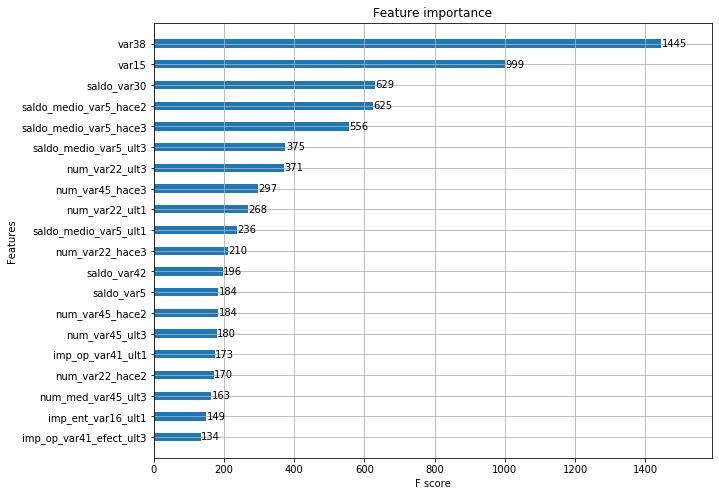

In [25]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)
plt.show()